# Just an example.You can alter sample code anywhere.

## Mount your google drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# # You need to modify this part to the directory where your code is located
# %cd "/content/drive/MyDrive/DL_Lab1/"

## Import packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import model
import pickle
import math
from tqdm import tqdm
import os

In [4]:
#Fix the random seed
np.random.seed(0)

## Load the data and label

In [5]:
train_load = np.loadtxt('./data/kmnist-train.csv',delimiter=',',dtype="int")
train_data=train_load[:,1:]
train_label=train_load[:,0]
print("shape of train_data: {}".format(train_data.shape))
print("shape of train_label: {}".format(train_label.shape))

shape of train_data: (60000, 784)
shape of train_label: (60000,)


## Show the training data

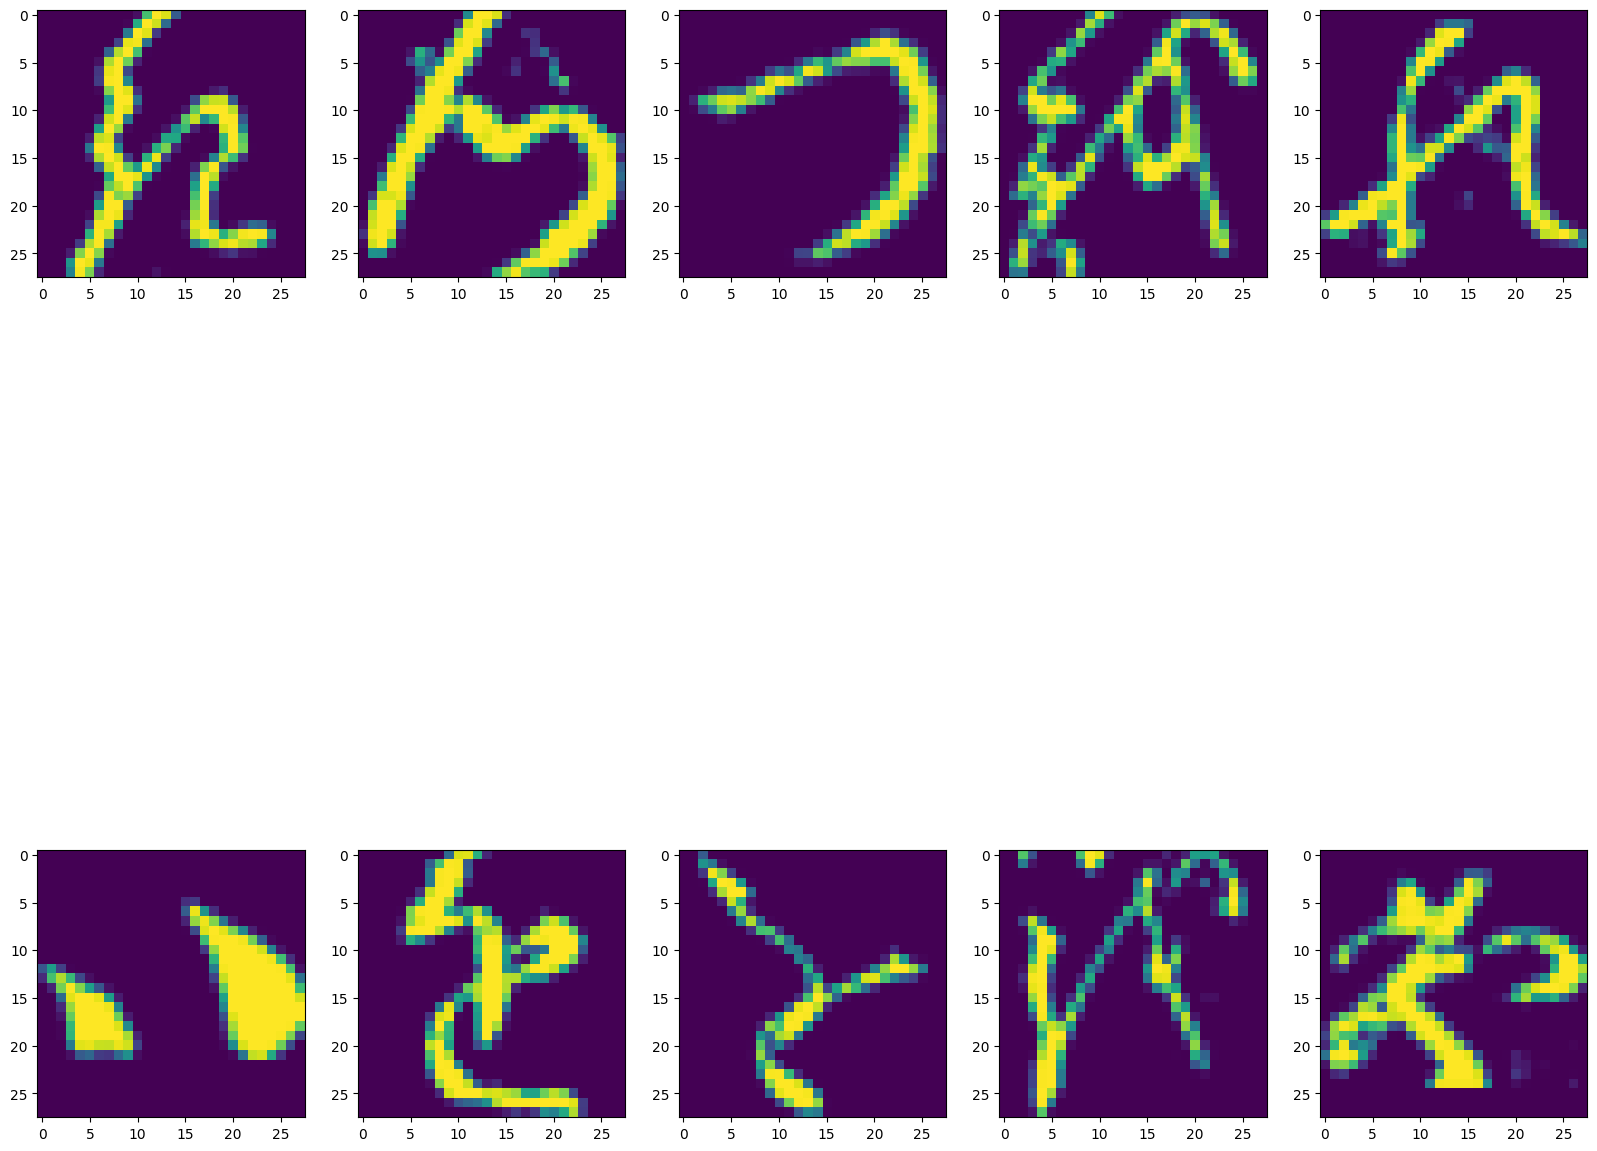

In [6]:
# uncomment if you want to show the training data
plt.figure(figsize=(20, 20))
for index in range(10):
   image = train_data[index+20000].reshape(28,28)
   plt.subplot(2, 5, index+1)
   plt.imshow(image)
plt.show()

In [7]:
train_image_num = train_data.shape[0]
train_data = train_data.astype('float32')

print("train_image_num  is : {}".format(train_image_num))

train_image_num  is : 60000


## Change numpy array to pytorch tensor

In [8]:
train_data_tensor = torch.from_numpy(train_data)
train_label_tensor = torch.from_numpy(train_label)

## Validation image number

In [9]:
val_image_num=10000

## Convert labels to one hot vector


In [10]:
label_temp = np.zeros((train_image_num, 10), dtype = np.float32)
for i in range(train_image_num):
    label_temp[i][train_label[i]] = 1
train_label_onehot = np.copy(label_temp)
train_label_onehot_tensor = torch.from_numpy(train_label_onehot)
print("One-hot training labels shape:",train_label_onehot.shape)


One-hot training labels shape: (60000, 10)


## Hyperparameters

In [11]:
EPOCH = 20
Batch_size = 100  # 10000 should be divisible by batch_size
Learning_rate = 0.001

## Define the models with pytorch

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layer
        self.fc1 = nn.Linear(in_features=7 * 7 * 32, out_features=128)
        self.bn3 = nn.BatchNorm1d(128)

        # Output layer
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        # Pass through convolutional layers
        x = self.pool1(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.leaky_relu(self.bn2(self.conv2(x))))
        
        # Flatten the tensor for fully connected layers
        x = x.view(x.size(0), -1)

        # Pass through fully connected layers with dropout
        x = F.leaky_relu(self.bn3(self.fc1(x)))
        x = self.fc2(x)
        
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print('Device : ', device)
net = Net()
net = net.to(device)

Device :  cuda


## Criterion and Optimizer

In [13]:
import torch.optim as optim

train_batch_num = (train_image_num - val_image_num) // Batch_size
val_batch_num = val_image_num // Batch_size

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCH*train_batch_num)
criterion = criterion = nn.CrossEntropyLoss()

## Training

In [14]:
best_val_loss = float('inf')
history = []

for epoch in range(1, EPOCH+1):
    train_hit, val_hit = 0, 0
    total_train_loss, total_val_loss = 0.0, 0.0
    lrs = []
    result = {'train_loss': [], 'valid_loss': [], 'lrs': []}
    
    # Use tqdm to display progress for each batch in the training process
    with tqdm(total=train_batch_num, desc=f"Epoch {epoch}/{EPOCH}", unit="batch") as pbar:
        for it in range(train_batch_num):

            optimizer.zero_grad()

            # Move inputs and labels to device
            inputs = train_data_tensor[it * Batch_size:(it + 1) * Batch_size].view(-1, 1, 28, 28).to(device)
            labels = train_label_tensor[it * Batch_size:(it + 1) * Batch_size].to(device)
            labels_onehot = train_label_onehot_tensor[it * Batch_size:(it + 1) * Batch_size].to(device)

            # Forward pass
            outputs = net(inputs)
            
            # Get predicted class
            _, pred_index = torch.max(outputs, 1)
            
            # Calculate train hit count
            train_hit += (pred_index == labels).sum().item()
            
            # Compute loss
            loss = criterion(outputs, labels_onehot)
            loss.backward()

            optimizer.step()

            total_train_loss += loss.item()
            
            # Update the tqdm progress bar
            pbar.set_postfix({"Train Loss": total_train_loss / (it + 1), "Train Acc": train_hit / ((it + 1) * Batch_size) * 100.0})
            pbar.update(1)

            lrs.append(optimizer.param_groups[0]['lr'])

            scheduler.step()

    with torch.no_grad():
        for titt in range(val_batch_num):
            tit = train_batch_num + titt
            
            # Move inputs and labels to device for validation
            inputs = train_data_tensor[tit * Batch_size:(tit + 1) * Batch_size].view(-1, 1, 28, 28).to(device)
            labels = train_label_tensor[tit * Batch_size:(tit + 1) * Batch_size].to(device)
            labels_onehot = train_label_onehot_tensor[tit * Batch_size:(tit + 1) * Batch_size].to(device)

            # Forward pass for validation
            outputs = net(inputs)
            
            # Get predicted class
            _, pred_index = torch.max(outputs, 1)
            
            # Calculate validation hit count
            val_hit += (pred_index == labels).sum().item()
            
            # Compute validation loss
            loss = criterion(outputs, labels_onehot)
            total_val_loss += loss.item()

    # Calculate and print final statistics after each epoch
    train_loss = total_train_loss / train_batch_num
    val_loss = total_val_loss / val_batch_num
    train_acc = train_hit / (train_image_num - val_image_num) * 100.0
    val_acc = val_hit / val_image_num * 100.0

    result['train_loss'] = train_loss
    result['valid_loss'] = val_loss
    result['lrs'] = lrs
    history.append(result)

    print(f'Task2  | Epoch: {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}'
          f' | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

    # Save the model if the validation loss decreases
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(net.state_dict(), 'best_model.pth')
        print(f"New best model saved with validation loss: {best_val_loss:.4f}")

Epoch 1/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch 1/20: 100%|██████████| 500/500 [00:05<00:00, 98.61batch/s, Train Loss=0.287, Train Acc=92.2] 


Task2  | Epoch:   1 | Train Loss: 0.2874 | Train Acc: 92.2100 | Val Loss: 0.1173 | Val Acc: 96.7300
New best model saved with validation loss: 0.1173


Epoch 2/20: 100%|██████████| 500/500 [00:02<00:00, 189.81batch/s, Train Loss=0.0881, Train Acc=97.8]


Task2  | Epoch:   2 | Train Loss: 0.0881 | Train Acc: 97.8140 | Val Loss: 0.0845 | Val Acc: 97.6000
New best model saved with validation loss: 0.0845


Epoch 3/20: 100%|██████████| 500/500 [00:02<00:00, 170.08batch/s, Train Loss=0.0507, Train Acc=98.9]


Task2  | Epoch:   3 | Train Loss: 0.0507 | Train Acc: 98.9000 | Val Loss: 0.0728 | Val Acc: 97.8900
New best model saved with validation loss: 0.0728


Epoch 4/20: 100%|██████████| 500/500 [00:02<00:00, 192.49batch/s, Train Loss=0.0304, Train Acc=99.5]


Task2  | Epoch:   4 | Train Loss: 0.0304 | Train Acc: 99.4960 | Val Loss: 0.0676 | Val Acc: 98.0100
New best model saved with validation loss: 0.0676


Epoch 5/20: 100%|██████████| 500/500 [00:02<00:00, 195.28batch/s, Train Loss=0.0188, Train Acc=99.8]


Task2  | Epoch:   5 | Train Loss: 0.0188 | Train Acc: 99.7820 | Val Loss: 0.0650 | Val Acc: 98.0200
New best model saved with validation loss: 0.0650


Epoch 6/20: 100%|██████████| 500/500 [00:02<00:00, 188.23batch/s, Train Loss=0.012, Train Acc=99.9] 


Task2  | Epoch:   6 | Train Loss: 0.0120 | Train Acc: 99.9300 | Val Loss: 0.0636 | Val Acc: 98.0800
New best model saved with validation loss: 0.0636


Epoch 7/20: 100%|██████████| 500/500 [00:02<00:00, 196.02batch/s, Train Loss=0.00805, Train Acc=100]


Task2  | Epoch:   7 | Train Loss: 0.0080 | Train Acc: 99.9780 | Val Loss: 0.0629 | Val Acc: 98.2100
New best model saved with validation loss: 0.0629


Epoch 8/20: 100%|██████████| 500/500 [00:02<00:00, 200.44batch/s, Train Loss=0.00588, Train Acc=100]


Task2  | Epoch:   8 | Train Loss: 0.0059 | Train Acc: 99.9980 | Val Loss: 0.0622 | Val Acc: 98.2600
New best model saved with validation loss: 0.0622


Epoch 9/20: 100%|██████████| 500/500 [00:02<00:00, 187.96batch/s, Train Loss=0.0047, Train Acc=100] 


Task2  | Epoch:   9 | Train Loss: 0.0047 | Train Acc: 100.0000 | Val Loss: 0.0620 | Val Acc: 98.2600
New best model saved with validation loss: 0.0620


Epoch 10/20: 100%|██████████| 500/500 [00:02<00:00, 192.35batch/s, Train Loss=0.00398, Train Acc=100]


Task2  | Epoch:  10 | Train Loss: 0.0040 | Train Acc: 100.0000 | Val Loss: 0.0618 | Val Acc: 98.2800
New best model saved with validation loss: 0.0618


Epoch 11/20: 100%|██████████| 500/500 [00:02<00:00, 199.86batch/s, Train Loss=0.0035, Train Acc=100] 


Task2  | Epoch:  11 | Train Loss: 0.0035 | Train Acc: 100.0000 | Val Loss: 0.0617 | Val Acc: 98.3300
New best model saved with validation loss: 0.0617


Epoch 12/20: 100%|██████████| 500/500 [00:02<00:00, 190.45batch/s, Train Loss=0.00317, Train Acc=100]


Task2  | Epoch:  12 | Train Loss: 0.0032 | Train Acc: 100.0000 | Val Loss: 0.0617 | Val Acc: 98.3300
New best model saved with validation loss: 0.0617


Epoch 13/20: 100%|██████████| 500/500 [00:02<00:00, 194.73batch/s, Train Loss=0.00293, Train Acc=100]


Task2  | Epoch:  13 | Train Loss: 0.0029 | Train Acc: 100.0000 | Val Loss: 0.0616 | Val Acc: 98.3100
New best model saved with validation loss: 0.0616


Epoch 14/20: 100%|██████████| 500/500 [00:02<00:00, 195.54batch/s, Train Loss=0.00276, Train Acc=100]


Task2  | Epoch:  14 | Train Loss: 0.0028 | Train Acc: 100.0000 | Val Loss: 0.0616 | Val Acc: 98.3200
New best model saved with validation loss: 0.0616


Epoch 15/20: 100%|██████████| 500/500 [00:02<00:00, 196.49batch/s, Train Loss=0.00264, Train Acc=100]


Task2  | Epoch:  15 | Train Loss: 0.0026 | Train Acc: 100.0000 | Val Loss: 0.0616 | Val Acc: 98.2900
New best model saved with validation loss: 0.0616


Epoch 16/20: 100%|██████████| 500/500 [00:02<00:00, 196.36batch/s, Train Loss=0.00255, Train Acc=100]


Task2  | Epoch:  16 | Train Loss: 0.0025 | Train Acc: 100.0000 | Val Loss: 0.0616 | Val Acc: 98.2900


Epoch 17/20: 100%|██████████| 500/500 [00:02<00:00, 201.28batch/s, Train Loss=0.00248, Train Acc=100]


Task2  | Epoch:  17 | Train Loss: 0.0025 | Train Acc: 100.0000 | Val Loss: 0.0616 | Val Acc: 98.3100


Epoch 18/20: 100%|██████████| 500/500 [00:02<00:00, 188.21batch/s, Train Loss=0.00244, Train Acc=100]


Task2  | Epoch:  18 | Train Loss: 0.0024 | Train Acc: 100.0000 | Val Loss: 0.0616 | Val Acc: 98.3100


Epoch 19/20: 100%|██████████| 500/500 [00:02<00:00, 179.33batch/s, Train Loss=0.00241, Train Acc=100]


Task2  | Epoch:  19 | Train Loss: 0.0024 | Train Acc: 100.0000 | Val Loss: 0.0616 | Val Acc: 98.3100


Epoch 20/20: 100%|██████████| 500/500 [00:02<00:00, 190.81batch/s, Train Loss=0.0024, Train Acc=100] 


Task2  | Epoch:  20 | Train Loss: 0.0024 | Train Acc: 100.0000 | Val Loss: 0.0616 | Val Acc: 98.3100


# Plotting

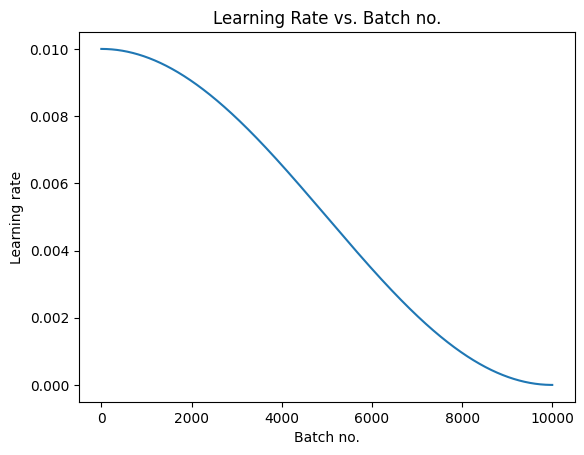

In [15]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch no.')
  plt.ylabel('Learning rate')
  plt.title('Learning Rate vs. Batch no.')

plot_lrs(history)

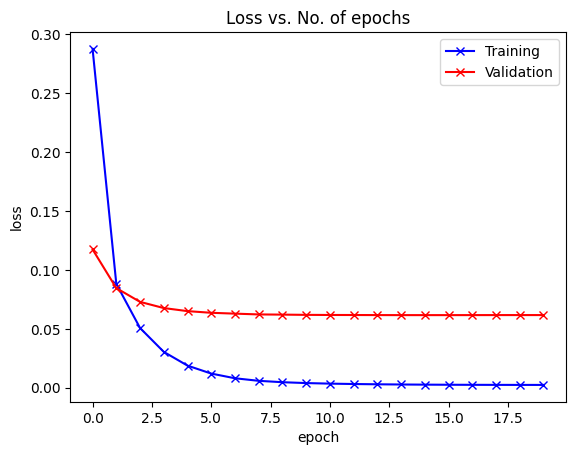

In [16]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['valid_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs')

plot_losses(history)